In [1]:
import numpy as np

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from torch.nn.utils import clip_grad_norm_

from lagom.networks import BaseNetwork
from lagom.networks import make_fc
from lagom.networks import ortho_init
from lagom.networks import linear_lr_scheduler

from lagom.policies import BasePolicy
from lagom.policies import CategoricalHead
from lagom.policies import DiagGaussianHead
from lagom.policies import constraint_action

from lagom.value

from lagom.transform import Standardize

from lagom.agents import BaseAgent


class MLP(BaseNetwork):
    def make_params(self, config):
        self.feature_layers = make_fc(self.env_spec.observation_space.flat_dim, config['network.hidden_sizes'])
        
    def init_params(self, config):
        for layer in self.feature_layers:
            ortho_init(layer, nonlinearity='tanh', constant_bias=0.0)
        
    def reset(self, config, **kwargs):
        pass
        
    def forward(self, x):
        for layer in self.feature_layers:
            x = torch.tanh(layer(x))
            
        return x
    
    
class Policy(BasePolicy):
    def make_networks(self, config):
        self.feature_network = MLP(config, self.device, env_spec=self.env_spec)
        feature_dim = config['network.hidden_sizes'][-1]
        
        if self.env_spec.control_type == 'Discrete':
            self.action_head = CategoricalHead(config, self.device, feature_dim, self.env_spec)
        elif self.env_spec.control_type == 'Continuous':
            self.action_head = DiagGaussianHead(config, 
                                                self.device, 
                                                feature_dim, 
                                                self.env_spec, 
                                                min_std=config['agent.min_std'], 
                                                std_style=config['agent.std_style'], 
                                                constant_std=config['agent.constant_std'],
                                                std_state_dependent=config['agent.std_state_dependent'],
                                                init_std=config['agent.init_std'])
    
    @property
    def recurrent(self):
        return False
    
    def reset(self, config, **kwargs):
        pass

    def __call__(self, x, out_keys=['action'], info={}, **kwargs):
        out = {}
        
        features = self.feature_network(x)
        action_dist = self.action_head(features)
        
        action = action_dist.sample().detach()################################
        out['action'] = action
        
        if 'action_logprob' in out_keys:
            out['action_logprob'] = action_dist.log_prob(action)
        if 'entropy' in out_keys:
            out['entropy'] = action_dist.entropy()
        if 'perplexity' in out_keys:
            out['perplexity'] = action_dist.perplexity()
        
        return out
    

class Agent(BaseAgent):
    r"""REINFORCE (no baseline). """
    def make_modules(self, config):
        self.policy = Policy(config, self.env_spec, self.device)
        
    def prepare(self, config, **kwargs):
        self.total_T = 0
        self.optimizer = optim.Adam(self.policy.parameters(), lr=config['algo.lr'])
        if config['algo.use_lr_scheduler']:
            if 'train.iter' in config:
                self.lr_scheduler = linear_lr_scheduler(self.optimizer, config['train.iter'], 'iteration-based')
            elif 'train.timestep' in config:
                self.lr_scheduler = linear_lr_scheduler(self.optimizer, config['train.timestep']+1, 'timestep-based')
        else:
            self.lr_scheduler = None
                

    def reset(self, config, **kwargs):
        pass

    def choose_action(self, obs, info={}):
        obs = torch.from_numpy(np.asarray(obs)).float().to(self.device)
        
        out = self.policy(obs, out_keys=['action', 'action_logprob', 'entropy'], info=info)
            
        # sanity check for NaN
        if torch.any(torch.isnan(out['action'])):
            while True:
                print('NaN !')
        if self.env_spec.control_type == 'Continuous':
            out['action'] = constraint_action(self.env_spec, out['action'])
            
        return out

    def learn(self, D, info={}):
        batch_policy_loss = []
        batch_entropy_loss = []
        batch_total_loss = []
        
        for trajectory in D:
            logprobs = trajectory.all_info('action_logprob')
            entropies = trajectory.all_info('entropy')
            Qs = trajectory.all_discounted_returns(self.config['algo.gamma'])
            
            # Standardize: encourage/discourage half of performed actions
            if self.config['agent.standardize_Q']:
                Qs = Standardize()(Qs, -1).tolist()
            
            policy_loss = []
            entropy_loss = []
            for logprob, entropy, Q in zip(logprobs, entropies, Qs):
                policy_loss.append(-logprob*Q)
                entropy_loss.append(-entropy)
            
            policy_loss = torch.stack(policy_loss).mean()
            entropy_loss = torch.stack(entropy_loss).mean()
            
            entropy_coef = self.config['agent.entropy_coef']
            total_loss = policy_loss + entropy_coef*entropy_loss
            
            batch_policy_loss.append(policy_loss)
            batch_entropy_loss.append(entropy_loss)
            batch_total_loss.append(total_loss)
            
        policy_loss = torch.stack(batch_policy_loss).mean()
        entropy_loss = torch.stack(batch_entropy_loss).mean()
        loss = torch.stack(batch_total_loss).mean()
        
        self.optimizer.zero_grad()
        loss.backward()
        
        if self.config['agent.max_grad_norm'] is not None:
            clip_grad_norm_(self.parameters(), self.config['agent.max_grad_norm'])
            
        if self.lr_scheduler is not None:
            if self.lr_scheduler.mode == 'iteration-based':
                self.lr_scheduler.step()
            elif self.lr_scheduler.mode == 'timestep-based':
                self.lr_scheduler.step(self.total_T)

        self.optimizer.step()
        
        self.total_T += sum([trajectory.T for trajectory in D])
        
        out = {}
        out['loss'] = loss.item()
        out['policy_loss'] = policy_loss.item()
        out['entropy_loss'] = entropy_loss.item()
        if self.lr_scheduler is not None:
            out['current_lr'] = self.lr_scheduler.get_lr()

        return out
    
    @property
    def recurrent(self):
        pass


ImportError: libcudart.so.9.2: cannot open shared object file: No such file or directory

In [24]:
from pathlib import Path
from lagom.experiment import Configurator

from lagom import pickle_load

from lagom.core.plotter import CurvePlot

In [25]:
log_folder = Path('logs')

list_config = pickle_load(log_folder/'configs.pkl')
configs = Configurator.to_dataframe(list_config)
configs

,ID,cuda,env.id,env.standardize,network.recurrent,network.hidden_sizes,algo.lr,algo.use_lr_scheduler,algo.gamma,agent.standardize_Q,...,agent.constant_std,agent.std_state_dependent,agent.init_std,train.timestep,train.N,train.T,eval.N,log.record_interval,log.print_interval,log.dir
0,0,True,HalfCheetah-v2,True,True,[8],0.001,True,0.99,True,...,None,False,1.0,1000000.0,1,200,10,100,500,logs


In [26]:
def load_results(log_folder, ID, f):
    p = Path(log_folder)/str(ID)
    
    list_result = []
    for sub in p.iterdir():
        if sub.is_dir() and (sub/f).exists():
            list_result.append(pickle_load(sub/f))
            
    return list_result


def get_returns(list_result):
    returns = []
    for result in list_result:
        #x_values = [i['evaluation_iteration'][0] for i in result]
        x_values = [i['accumulated_trained_timesteps'][0] for i in result]
        y_values = [i['average_return'][0] for i in result]
        returns.append([x_values, y_values])
        
    return returns


In [27]:
ID = 0
env_id = configs.loc[configs['ID'] == ID]['env.id'].values[0]

In [28]:
list_result = load_results('logs', ID, 'eval_logs.pkl')
returns = get_returns(list_result)
x_values, y_values = zip(*returns)

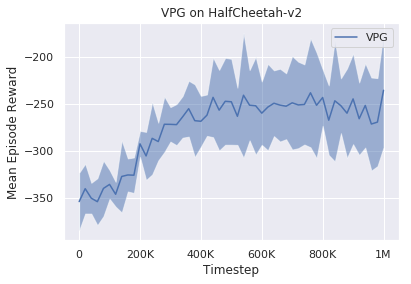

In [29]:
plot = CurvePlot()
plot.add('VPG', y_values, xvalues=x_values)
ax = plot(title=f'VPG on {env_id}', 
          xlabel='Timestep', 
          ylabel='Mean Episode Reward', 
          num_tick=6, 
          xscale_magnitude=None)

In [11]:
ax.figure.savefig('data/result.png')